<a href="https://colab.research.google.com/github/szeshiang/Deep-Learning/blob/main/10_Mar_24_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Transfer Learning**

- Imagenet dataset
- Pre-trained models

**Case 1**

- When images are in folder according to class labels (dataset hierarchy)
- code split into 80% and 20%



In [28]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL        #Python Imaging Library
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [29]:
import pathlib   # when working with data in url/paths
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [30]:
data_dir = pathlib.Path(data_dir)

image_count = len(list(data_dir.glob('*/*.jpg')))    # glob is useful especially when working with CNN
print(image_count)

3670


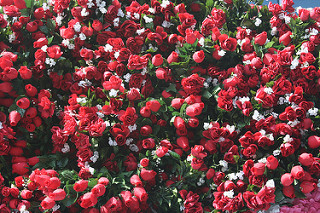

In [31]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

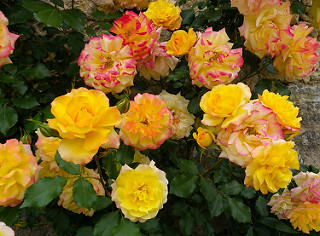

In [32]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

In [33]:
sub_folders = [i for i in data_dir.iterdir() if i.is_dir()]

print("Label names:")
for label in sub_folders:
    print(label.name)


Label names:
dandelion
daisy
sunflowers
roses
tulips


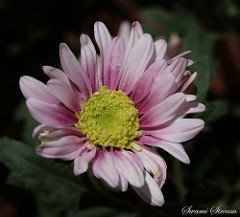

In [34]:
daisy = list(data_dir.glob('daisy/*'))
PIL.Image.open(str(daisy[0]))

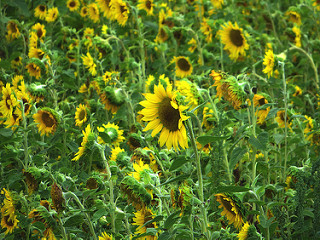

In [35]:
sunflowers = list(data_dir.glob('sunflowers/*'))
PIL.Image.open(str(sunflowers[0]))

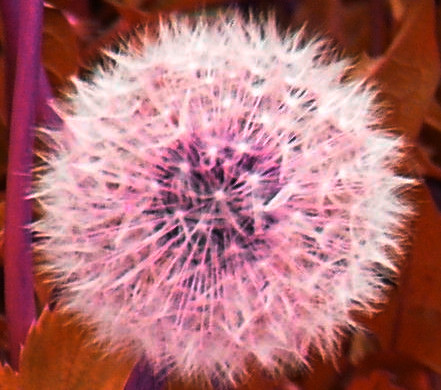

In [36]:
dandelion = list(data_dir.glob('dandelion/*'))
PIL.Image.open(str(dandelion[0]))

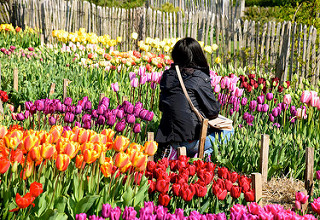

In [37]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

**Training Dataset**

In [38]:
# Creating a training dataset
train_ds=tf.keras.utils.image_dataset_from_directory(data_dir,
                                                     validation_split=0.2,
                                                     subset='training',
                                                     seed=123,
                                                     image_size=(180,180),
                                                     batch_size=32
                                                     )

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


**The need to resize**

the images might be all in different sizes. and CNN requires images to be of equal sizes

In [39]:
image_roses=data_dir/'roses'
img_files=list(image_roses.glob('*.jpg'))

rose_image=img_files[0]
image=PIL.Image.open(rose_image)
print(image.height,image.width)

213 320


In [40]:
rose_image=img_files[1]
image=PIL.Image.open(rose_image)
print(image.height,image.width)

236 320


In [41]:
rose_image=img_files[10]
image=PIL.Image.open(rose_image)
print(image.height,image.width)

256 320


**Validation Dataset**

In [42]:
# creating a validation dataset
test_ds=tf.keras.utils.image_dataset_from_directory(data_dir,
                                                     validation_split=0.2,
                                                     subset='validation',
                                                     seed=123,
                                                     image_size=(180,180),
                                                     batch_size=32)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [43]:
class_names=train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


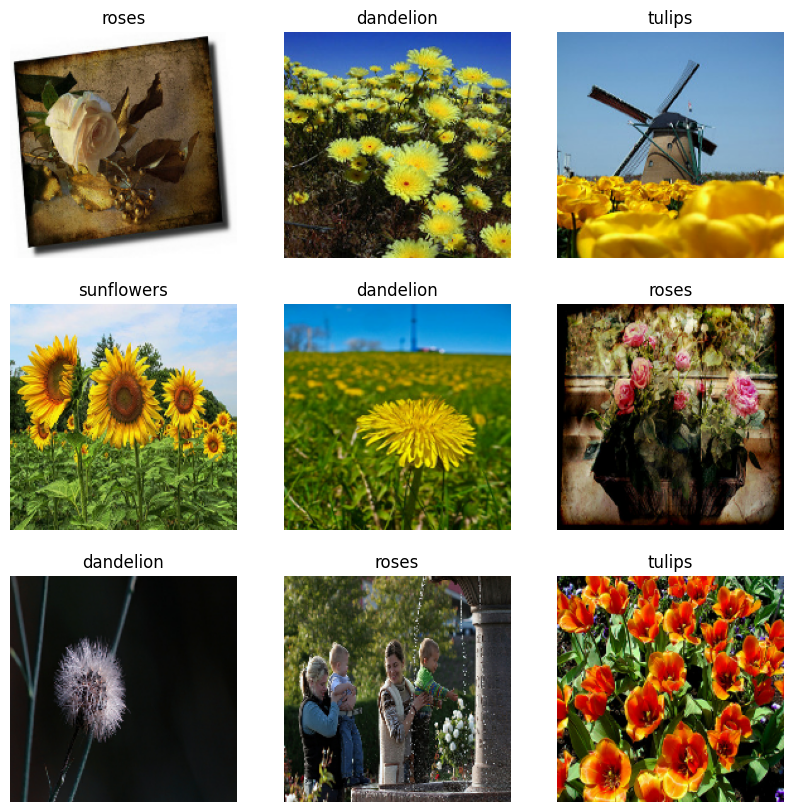

In [44]:
# display images
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):   # (1) just means 1st batch of images out of the batch size of 32
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))   # to convert tensorflow tensor images to numpy for display; astype is used to change the type
    plt.title(class_names[labels[i]])
    plt.axis("off")

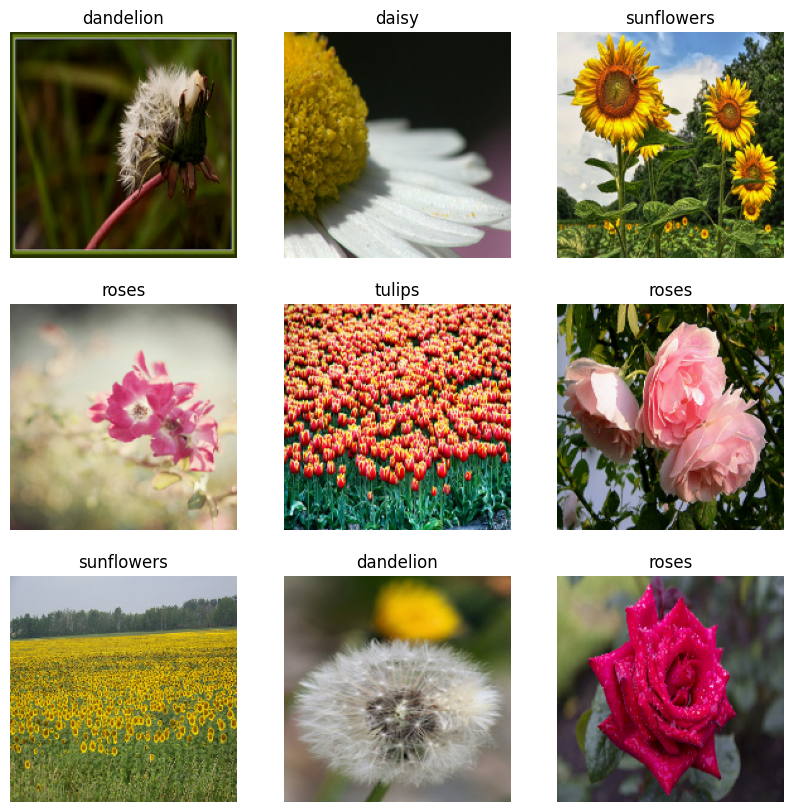

In [45]:
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


**Steps**
- Data Preprocessing: normalisation, data augementation, CNN architecture
-



** Tuning the num of parallel calls during data preprocessing, transformation operations

** Caching will read the data

** prefetch - fetch data from background while model is training. this will improve performance

In [46]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [47]:
# data Normalization
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

# to see image after normalised
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


**Data Augmentation**

In [48]:
batch_size = 32
img_height = 180
img_width = 180

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

**Transfer Learning - Feature Extraction using Pre-Trained NN**

In [49]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

keras.applications.VGG16(

    include_top=True,   # output layer is the top
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",

)

> this is the original VGG16 model. but we will be making some changes and fine-tuning to the output layer

> include_top: whether to include the 3 fully-connected layers at the top of the network.

In [50]:
# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(180, 180, 3))
# Freeze the weights of the pre-trained layers
base_model.trainable=False

In [51]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

**Add Output**

In [52]:
inputs = tf.keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = normalization_layer(x)
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
output = Dense(5, activation='softmax')(x)
# Create the new model
model = Model(inputs=base_model.input, outputs=output)

In [53]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [54]:
# Compile and train the model on the new dataset
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [55]:
# run
model.fit(train_ds, epochs=2, validation_data=(test_ds))

Epoch 1/2
92/92 [==============================] - 29s 230ms/step - loss: 4.6289 - accuracy: 0.7112 - val_loss: 0.8307 - val_accuracy: 0.7520
Epoch 2/2
92/92 [==============================] - 12s 126ms/step - loss: 0.3275 - accuracy: 0.8941 - val_loss: 1.0110 - val_accuracy: 0.8106


In [56]:
# test accuracy
print('test_score', model.evaluate(test_ds))

23/23 [==============================] - 2s 97ms/step - loss: 1.0110 - accuracy: 0.8106
test_score [1.0110009908676147, 0.8106266856193542]


In [58]:
# train accuracy
print('Train Score',model.evaluate(train_ds))

92/92 [==============================] - 9s 101ms/step - loss: 0.1079 - accuracy: 0.9619
Train Score [0.10792697221040726, 0.9618528485298157]


**Transfer Learning - Fine Tuning**

- using the pre-trained model, decided how many layers to freeze and train the rest ~ purely exploratory based on output accuracy

In [59]:
# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(180, 180, 3))
# Freeze the initial layers and fine-tune the later layers
for layer in base_model.layers[:15]:
    layer.trainable = False
for layer in base_model.layers[15:]:
    layer.trainable = True

In [60]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [61]:
# Add new classification layers
inputs = tf.keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = normalization_layer(x)
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
output = Dense(5, activation='softmax')(x)
# Create the new model
model = Model(inputs=base_model.input, outputs=output)

In [62]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0   

In [63]:
# Compile and train the model on the new dataset
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [64]:
model.fit(train_ds, epochs=3, validation_data=(test_ds))

Epoch 1/3
92/92 [==============================] - 16s 137ms/step - loss: 2.9555 - accuracy: 0.2132 - val_loss: 1.6035 - val_accuracy: 0.2398
Epoch 2/3
92/92 [==============================] - 12s 133ms/step - loss: 1.6801 - accuracy: 0.2486 - val_loss: 1.6013 - val_accuracy: 0.2384
Epoch 3/3
92/92 [==============================] - 13s 138ms/step - loss: 1.7202 - accuracy: 0.2463 - val_loss: 1.6009 - val_accuracy: 0.2398


>> There could be reasons why performance dropped. Could be due to small dataset or VGG16 not suitable, etc

**9 Mar 24_Image Classification with CNN exercise**

In [22]:
num_classes = len(class_names)
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [24]:
model.compile(optimizer='adam',             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# run
epochs=3
history=model.fit(train_ds,
                  validation_data=test_ds,
                  epochs=epochs)

Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


92/92 [==============================] - 11s 52ms/step - loss: 1.3272 - accuracy: 0.4046 - val_loss: 1.1215 - val_accuracy: 0.5354
Epoch 2/3
92/92 [==============================] - 3s 29ms/step - loss: 1.0757 - accuracy: 0.5654 - val_loss: 1.0039 - val_accuracy: 0.5967
Epoch 3/3
92/92 [==============================] - 3s 31ms/step - loss: 0.9631 - accuracy: 0.6202 - val_loss: 0.9272 - val_accuracy: 0.6281


In [ ]:
# test accuracy
print('test_score', model.evaluate(test_ds))

23/23 [==============================] - 0s 12ms/step - loss: 0.9272 - accuracy: 0.6281
test_score [0.9271621108055115, 0.6280654072761536]


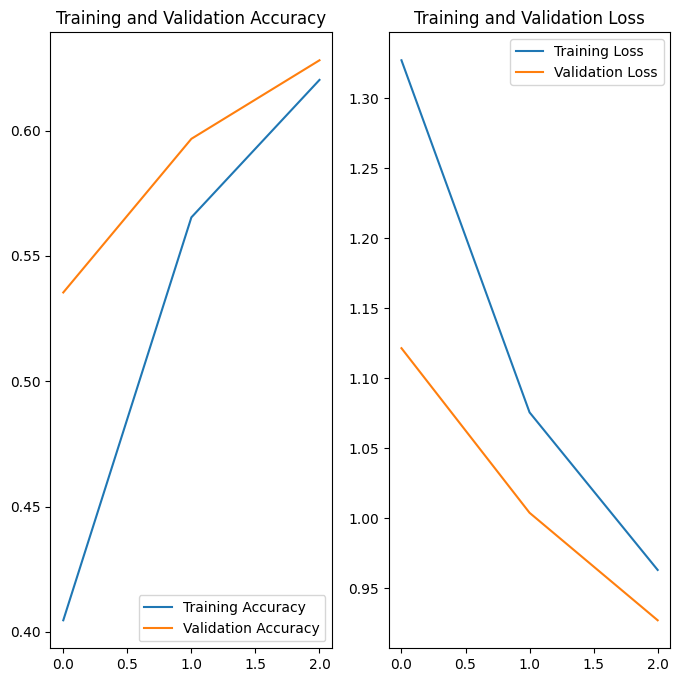

In [ ]:
# plot the accuracy graph
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 295ms/step
This image most likely belongs to tulips with a 27.41 percent confidence.
